# Reducing Death Rate from Heart Failure

## What are the early indicators? 

## Goals

My goal for this project is to create a model that will predict heart failure using the clinical data provided. 
Equally important, I would like to identify which of these conditions and attributes are the biggest drivers for heart failure. 
I will deliver the following: acquire.py, prepare.py, model.py, report.ipynb, and predictions.csv

## Acquire

acquire data from csv gathered from kaggle.com

In [1]:
# prepare environment

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# read csv
file = 'heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(file)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# for acquire.py 

import pandas as pd

def acquire(file):
    df = pd.read_csv(file)
    return df

In [4]:
# test my function
df = acquire(file)

## Prepare

Summarize Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
age                         299 non-null float64
anaemia                     299 non-null int64
creatinine_phosphokinase    299 non-null int64
diabetes                    299 non-null int64
ejection_fraction           299 non-null int64
high_blood_pressure         299 non-null int64
platelets                   299 non-null float64
serum_creatinine            299 non-null float64
serum_sodium                299 non-null int64
sex                         299 non-null int64
smoking                     299 non-null int64
time                        299 non-null int64
DEATH_EVENT                 299 non-null int64
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


- Data types look good
- No missing values
- Prob want to rename some columns

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


- Will definitely want to scale the data  
- Age: 40-95  
- Anemia: 43% are anemic  
- Creatinine_phosphokinase: 23-7861 with 75% at 582, so heavily skewed right.   
- Diabetes: 42% are diabetic. 
- Ejection_fraction: 14-80, seems pretty normally distributed.   
- High_blood_pressure: 35% have high bp. 
- Platelets: 25,100 - 850,000, slightly skewed right it seems, but not too bad, as the mean and median are very close. 
- Serum_creatinine: .5-9.4, with 75% at 1.4, so heavily skewed right. 
- Serum_sodium: 113-148, seems pretty normally distributed. 
- Sex: 64% are male? (if male is represented by 1)
- Smoking: 32% smoke. 
- Death_event: 32% do not survive.  

Outliers & Distributions

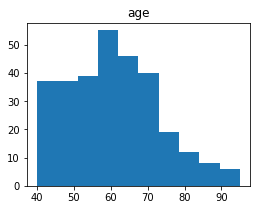

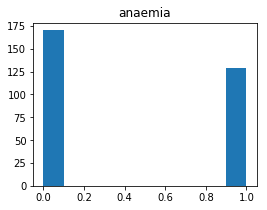

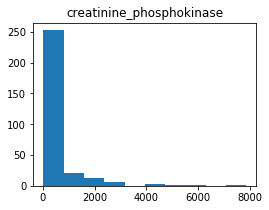

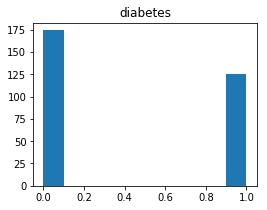

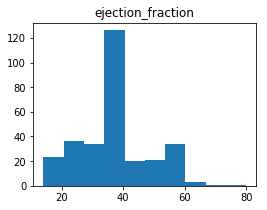

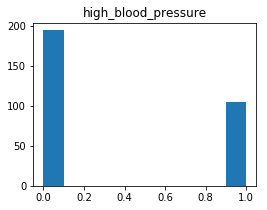

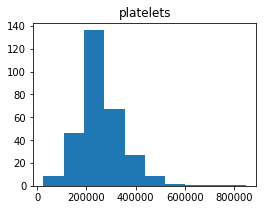

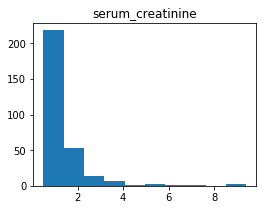

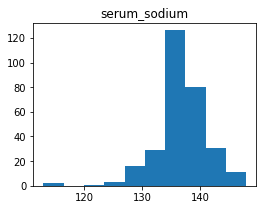

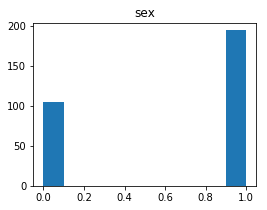

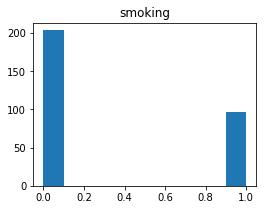

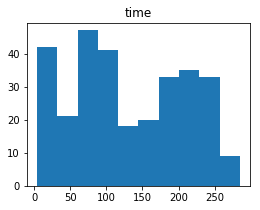

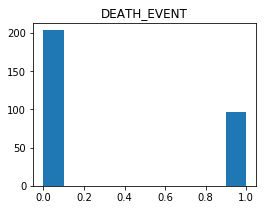

In [7]:
for col in df.columns:
    plt.figure(figsize=(4,3))
    plt.hist(df[col])
    plt.title(col)
    plt.show()

**prepare.py**

- address missing data
- address outliers
- create `risk_factor_count`: I'm not sure which variables to include in that until I do the testing on my hypotheses, but in the meantime, I will use HighBP, Smoking, Diabetes, & Anemia)
- split into train, validate, test

## Explore

- plot correlation matrix of all variables
- test each hypothesis
- are there cutoffs I should use to label each continuous feature as increased risk? Plot the continuous variables using a swarmplot or boxplot with death_event, and also observe the outcomes of the t-tests.  
- early thoughts: We could add a new feature that counts the number of risk factors.

### Early Hypotheses

#### Do those who do not survive have a higher number of risk factors than those who do survive?

$H_{0}: \mu(age_{death}) = \mu(age_{survival})$
$H_{a}: \mu(age_{death}) > \mu(age_{survival})$

In [8]:
# plot

In [9]:
# Test

In [ ]:
# summarize conclusion

Those who do not survive are older, on average, than those who do.

$H_{0}: \mu(age_{death}) = \mu(age_{survival})$
$H_{a}: \mu(age_{death}) > \mu(age_{survival})$

Those who do not survive have a higher ejection fraction, or percentage of blood leaving the heart at each contraction, on average, than those who do survive.

$H_{0}: \mu(EF_{death}) = \mu(EF_{survival})$
$H_{a}: \mu(EF_{death}) > \mu(EF_{survival})$

Those who do not survive have a significantly different levels of the creatinine phosphokinase enzyme in their blood, on average, than those who do survive.

$H_{0}: \mu(CPK_{death}) = \mu(CPK_{survival})$
$H_{a}: \mu(CPK_{death}) \ne \mu(CPK_{survival})$

Those who do not survive have a significantly different count of plateles in their blood, on average, than those who do survive.

$H_{0}: \mu(platelets_{death}) = \mu(platelets_{survival})$
$H_{a}: \mu(platelets_{death}) \ne \mu(platelets_{survival})$

Those who do not survive have a significantly different level of serum sodium in their blood, on average, than those who do survive.

$H_{0}: \mu(serumNA_{death}) = \mu(serumNA_{survival})$
$H_{a}: \mu(serumNA_{death}) \ne \mu(serumNA_{survival})$

Those who do not survive have a significantly different level of serum creatinine in their blood, on average, than those who do survive.

$H_{0}: \mu(serumCreat_{death}) = \mu(serumCreat_{survival})$
$H_{a}: \mu(serumCreat_{death}) \ne \mu(serumCreat_{survival})$

The proportion anemic patients who die from heart failure is significantly different that of non-anemic patients.

$H_{0}: P(death_{anemia}) = P(death_{noAnemia})$
$H_{a}: P(death_{anemia}) \ne P(death_{noAnemia})$

The proportion diabetic patients who die from heart failure is significantly different that of non-diabetic patients.

$H_{0}: P(death_{diabetes}) = P(death_{noDiabetes})$
$H_{a}: P(death_{diabetes}) \ne P(death_{noDiabetes})$

The proportion smoking patients who die from heart failure is significantly different that of non-smoking patients.

$H_{0}: P(death_{smoking}) = P(survival_{noSmoking})$
$H_{a}: P(death_{smoking}) \ne P(survival_{noSmoking})$

The proportion patients with high blood pressure who die from heart failure is significantly different that of patients without high blood pressure.

$H_{0}: P(death_{highBP}) = P(survival_{noHighBP})$
$H_{a}: P(death_{highBP}) \ne P(survival_{noHighBP})$

The proportion male patients who die from heart failure is significantly different that of female patients.

$H_{0}: P(death_{male}) = P(death_{female})$
$H_{a}: P(death_{male}) \ne P(death_{female})$

**Correlation Matrix**

In [ ]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Modeling

- try different algorithms: decision tree, logistic regression, random forest, knn, svm  
- which features are most influential? 
- evaluate on train
- select top 3 +/- models to evaluate on validate
- select top model  
- create a model.py that pulls all the parts together. 
- run model on test to verify. 

### Model 1: (name the model something useful)

- train 
- make predictions using X_train
- evaluate by comparing predictions to y_train

### Model 2: (name something useful)

- train 
- make predictions using X_train
- evaluate by comparing predictions to y_train

...


### Model n: (name something useful)

- train 
- make predictions using X_train
- evaluate by comparing predictions to y_train

### Validate Top 3 Models

- Which models should I validate? Why? 
- Make predictions using X_validate
- Evaluate by comparing predictions to y_validate

### Test Top Model

- Select the top model. Why did you select that model?   
- make predictions using X_test.  
- evaluate by comparing predictions to y_test.  
- summarize the evaluation in "plain english".  
- create a clean and labeled version of the confusion matrix as you will want to include that in your conclusion.  

### Making predictions

- Use your final model to make predictions for all existing observations.
- Concatenate the rows of X_train, X_validate, X_test, into X and sort by the index. 
- Make predictions using your model: y_pred = mymodel.predict(X)
- Concatenate a dataframe of y_pred onto onto the dataframe you split your train, validate, test samples from. (column concatenation)
- visualize predictions vs. actual

### Draw Conclusions

- summarize findings from analysis and modeling
- make recommendations
- next steps ("my next step will/would be")  
- summarize the final model...how will you expect it to perform on new data? where are possible gaps you see?